# Chatbot

Options :

In [1]:
train_model = True
#train_model = False

In [2]:
api = False
#api = True

Importer les modules nécessaires :

In [3]:
import json
import pandas as pd
from nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from nltk.corpus import stopwords 
from langdetect import detect
import unicodedata

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import random
import numpy as np

from keras.models import load_model

from flask import Flask, render_template, request

Obtenir la DataFrame à partir de ``content.json`` :

In [4]:
#ouvrir le fichier JSON
with open('content.json') as content:
  data1 = json.load(content)

#créer les listes vides
tags = []
inputs = []
responses={}
#les remplir avec le contenu du JSON
for intent in data1['intents']:
  responses[intent['tag']]=intent['liste_output']
  for lines in intent['liste_input']:
    inputs.append(lines)
    tags.append(intent['tag'])
    
#convertir en DataFrame
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

#mélanger aléatoirement
data = data.sample(frac=1)

#montrer la DataFrame
display(data)
#montrer les catégories
data["tags"].value_counts()

,inputs,tags
2,Ouais,affirmation
4,Oui s’il vous plaît,affirmation
44,Est ce que je peux intégrer la formation après...,admission
51,Y-a-t-il des cours de mathématiques ?,pédagogie
61,Comment se passe le stage en entreprise ?,alternance
...,...,...
50,Comment se passent les cours ?,pédagogie
7,Nan,negation
38,Comment intégrer la formation ?,admission
1,Yes,affirmation


debouches          12
admission          12
alternance         12
fin                 9
evaluation          9
salutation          9
pédagogie           8
aide financiere     6
affirmation         6
enseignants         5
apprenant           5
insultes            5
negation            5
titre               5
covid               5
partenaire          4
code                4
date                3
Name: tags, dtype: int64

Créer les fonctions de traitement du texte :

In [5]:
#enlever les accents du texte
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return str(only_ascii)[2:-1]

In [6]:
stop_words_en = list(set(stopwords.words('english')))
stop_words_fr = list(set(stopwords.words('french')))

In [7]:
stop_words_fr_1 = []
for word in stop_words_fr:
    word = remove_accents(word)
    stop_words_fr_1.append(word)
stop_words_fr = list(sorted(set(stop_words_fr + stop_words_fr_1)))
stop_words_fr

['a',
 'ai',
 'aie',
 'aient',
 'aies',
 'ait',
 'as',
 'au',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aux',
 'avaient',
 'avais',
 'avait',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avons',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'ayez',
 'ayons',
 'c',
 'ce',
 'ces',
 'd',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'es',
 'est',
 'et',
 'etaient',
 'etais',
 'etait',
 'etant',
 'etante',
 'etantes',
 'etants',
 'ete',
 'etee',
 'etees',
 'etes',
 'etiez',
 'etions',
 'eu',
 'eue',
 'eues',
 'eumes',
 'eurent',
 'eus',
 'eusse',
 'eussent',
 'eusses',
 'eussiez',
 'eussions',
 'eut',
 'eutes',
 'eux',
 'eûmes',
 'eût',
 'eûtes',
 'fumes',
 'furent',
 'fus',
 'fusse',
 'fussent',
 'fusses',
 'fussiez',
 'fussions',
 'fut',
 'futes',
 'fûmes',
 'fût',
 'fûtes',
 'il',
 'ils',
 'j',
 'je',
 'l',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'm',
 'ma',
 'mais',
 'me',
 'meme',
 'mes',
 'moi',
 'mon',
 'mêm

In [8]:
#traiter le texte
def treatment(text):
    #vérifier si c'est une question
    if text[-1] == "?":
        question = "?"
    else:
        question = "0"
        
    #vérifier la langue
    if detect(text) == "fr":
        language = "francais"
    elif detect(text) == "en":
        language = "anglais"
    else:
        language = "francais"
    
    #segmenter le texte et traiter chaque mot et chaque lettre
    text = text.split()
    words_list = []
    for word in text:
        letters_list = []
        for character in word:
            #vérifier que le caractère est une lettre
            if character.isalpha():
                #rajouter à la liste en minuscule
                letters_list.append(character.lower())
            else:
                letters_list.append(" ")
        word = "".join(letters_list)
        
        #appliquer le stemming suivant la langue
        for word1 in word.split():
            word_yes = False
            if language == "anglais":
                if word1 not in stop_words_en:
                    word1 = EnglishStemmer().stem(word1)
                    word_yes = True
            else:
                if word1 not in stop_words_fr:
                    word1 = FrenchStemmer().stem(word1)
                    word_yes = True
            #enlever les accents
            if word_yes == True:
                word1 = remove_accents(word1)
                words_list.append(word1)
            
    #joindre en une string
    text = " ".join(words_list)
    return " ".join([text, question, language])
    #pour avoir en trois colonnes
    #return [text, question, language]

Obtenir une colonne avec les inputs traités :

In [9]:
#pour avoir en trois colonnes

#text_list = []
#ques_list = []
#lang_list = []

#for value in data["inputs"]:
    #value = treatment(value)
    #text_list.append(value[0])
    #ques_list.append(value[1])
    #lang_list.append(value[2])

#data["text"] = text_list
#data["?"] = ques_list
#data["language"] = lang_list

In [10]:
data["texts"] = data["inputs"].apply(treatment)

In [11]:
data

,inputs,tags,texts
2,Ouais,affirmation,ouais 0 francais
4,Oui s’il vous plaît,affirmation,oui plait 0 francais
44,Est ce que je peux intégrer la formation après...,admission,peux integr format apres dat officiel rentr ? ...
51,Y-a-t-il des cours de mathématiques ?,pédagogie,cour mathemat ? francais
61,Comment se passe le stage en entreprise ?,alternance,comment pass stag entrepris ? francais
...,...,...,...
50,Comment se passent les cours ?,pédagogie,comment passent cour ? francais
7,Nan,negation,nan 0 francais
38,Comment intégrer la formation ?,admission,comment integr format ? francais
1,Yes,affirmation,ye 0 francais


Appliquer le tokenizer sur les inputs traités :

In [12]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['texts'])
train = tokenizer.texts_to_sequences(data['texts'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

Appliquer LabelEncoder() sur les tags :

In [13]:
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [14]:
input_shape = x_train.shape[1]
print(input_shape)

10


In [15]:
vocabulary = len(tokenizer.word_index)
print("Nombre de mots uniques : ",vocabulary)
output_length = le.classes_.shape[0]
print("Taille des outputs : ",output_length)

Nombre de mots uniques :  163
Taille des outputs :  18


Créer et entraîner le modèle :

In [16]:
if train_model == True:
    #créer le modèle
    i = Input(shape=(input_shape,))
    x = Embedding(vocabulary+1,10)(i)
    x = LSTM(10,return_sequences=True)(x)
    x = Flatten()(x)
    x = Dense(output_length,activation="softmax")(x)
    model  = Model(i,x)

    #compiler le modèle
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

    #entraîner le modèle
    train = model.fit(x_train,y_train,epochs=200)
    
    #sauvegarder le modèle
    model.save("chatbot.h5")

Epoch 1/200
4/4 [==============================] - 0s 5ms/step - loss: 2.8892 - accuracy: 0.0565
Epoch 2/200
4/4 [==============================] - 0s 5ms/step - loss: 2.8849 - accuracy: 0.0726
Epoch 3/200
4/4 [==============================] - 0s 5ms/step - loss: 2.8805 - accuracy: 0.1048
Epoch 4/200
4/4 [==============================] - 0s 5ms/step - loss: 2.8766 - accuracy: 0.0968
Epoch 5/200
4/4 [==============================] - 0s 5ms/step - loss: 2.8712 - accuracy: 0.0968
Epoch 6/200
4/4 [==============================] - 0s 5ms/step - loss: 2.8652 - accuracy: 0.1048
Epoch 7/200
4/4 [==============================] - 0s 5ms/step - loss: 2.8595 - accuracy: 0.1290
Epoch 8/200
4/4 [==============================] - 0s 5ms/step - loss: 2.8516 - accuracy: 0.1129
Epoch 9/200
4/4 [==============================] - 0s 6ms/step - loss: 2.8441 - accuracy: 0.1129
Epoch 10/200
4/4 [==============================] - 0s 5ms/step - loss: 2.8360 - accuracy: 0.1129
Epoch 11/200
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.9257 - accuracy: 0.8468
Epoch 85/200
4/4 [==============================] - 0s 4ms/step - loss: 0.9057 - accuracy: 0.8468
Epoch 86/200
4/4 [==============================] - 0s 4ms/step - loss: 0.8829 - accuracy: 0.8710
Epoch 87/200
4/4 [==============================] - 0s 4ms/step - loss: 0.8643 - accuracy: 0.8710
Epoch 88/200
4/4 [==============================] - 0s 4ms/step - loss: 0.8457 - accuracy: 0.8710
Epoch 89/200
4/4 [==============================] - 0s 4ms/step - loss: 0.8296 - accuracy: 0.8629
Epoch 90/200
4/4 [==============================] - 0s 4ms/step - loss: 0.8087 - accuracy: 0.8790
Epoch 91/200
4/4 [==============================] - 0s 4ms/step - loss: 0.7869 - accuracy: 0.8871
Epoch 92/200
4/4 [==============================] - 0s 4ms/step - loss: 0.7713 - accuracy: 0.8871
Epoch 93/200
4/4 [==============================] - 0s 4ms/step - loss: 0.7545 - accuracy: 0.8871
Epoch 94/200
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.2000 - accuracy: 0.9919
Epoch 167/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1991 - accuracy: 1.0000
Epoch 168/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1936 - accuracy: 0.9919
Epoch 169/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1892 - accuracy: 1.0000
Epoch 170/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1836 - accuracy: 1.0000
Epoch 171/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1828 - accuracy: 1.0000
Epoch 172/200
4/4 [==============================] - 0s 14ms/step - loss: 0.1802 - accuracy: 0.9919
Epoch 173/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1742 - accuracy: 1.0000
Epoch 174/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1753 - accuracy: 1.0000
Epoch 175/200
4/4 [==============================] - 0s 5ms/step - loss: 0.1703 - accuracy: 1.0000
Epoch 176/200
4/4 [====

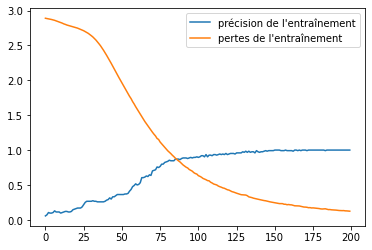

In [17]:
if train_model == True:
    #montrer l'historique de précision et des pertes
    plt.plot(train.history['accuracy'],label="précision de l'entraînement")
    plt.plot(train.history['loss'],label="pertes de l'entraînement")
    plt.legend()

In [18]:
if train_model == False:
    model = load_model("chatbot.h5")

## Test

Taper 0 pour sortir.

In [ ]:
if api == False:
    while True:
      texts_p = []
      prediction_input = input('You : ')
      if prediction_input == "0":
        break

      #removing punctuation and converting to lowercase
      prediction_input = treatment(prediction_input)
      texts_p.append(prediction_input)
      print(prediction_input)

      #tokenizing and padding
      prediction_input = tokenizer.texts_to_sequences(texts_p)
      prediction_input = np.array(prediction_input).reshape(-1)
      prediction_input = pad_sequences([prediction_input],input_shape)
      print(prediction_input)

      #getting output from model
      output = model.predict(prediction_input)
      output = output.argmax()
      print(output)

      #finding the right tag and predicting
      response_tag = le.inverse_transform([output])[0]
      print(response_tag)
      #print("Going Merry : ",random.choice(responses[response_tag]))
      if response_tag == "goodbye":
        break

You : Bonjour.
bonjour 0 francais
[[ 0  0  0  0  0  0  0 45  2  1]]
16
salutation
You : Quand commence la formation ?
quand commenc format ? francais
[[ 0  0  0  0  0  0  0 23  4  1]]
0
admission
You : Qui sont les enseignants ?
enseign ? francais
[[ 0  0  0  0  0  0  0  0 54  1]]
9
enseignants


## API

In [ ]:
if api == True:
    app = Flask(__name__)

    s_list = ["inconnu", "apprenant", "partenaire"]
    user_status = s_list[0]

    #créer deux listes de tags identifiant l'utilisateur comme étant apprenant ou partenaire
    appr_list = []
    part_list = []

    #créer deux dictionnaires avec les équivalents d'output apprenant/partenaire
    to_appr = {}
    to_part = {}


    #definir les app.route
    @app.route("/")
    def index():
        return render_template("index.html")

    @app.route("/get")
    #fonction de réponse
    def get_bot_response():
        #obtenir la question et la formatter
        texts_p = []
        prediction_input = request.args.get('msg')
        prediction_input = treatment(prediction_input)
        texts_p.append(prediction_input)

        #formatter l'input
        prediction_input = tokenizer.texts_to_sequences(texts_p)
        prediction_input = np.array(prediction_input).reshape(-1)
        prediction_input = pad_sequences([prediction_input],input_shape)

        #prédire l'output
        output = model.predict(prediction_input)
        output = output.argmax()

        #vérifier si l'output identifie l'utilisateur
        if output in appr_list:
            user_status = s_list[1]
        elif output in part_list:
            user_status = s_list[2]

        #si l'utilisateur est identifié et l'output est susceptible de changer pour ça, alors le changer
        if user_status == s_list[1] and output in to_appr.keys():
            output = to_appr[output]
        elif user_status == s_list[2] and output in to_part.keys():
            output = to_part[output]

        #transformer la réponse et la renvoyer
        response_tag = le.inverse_transform([output])[0]
        response = str("Chatbot : ",random.choice(responses[response_tag]))
        return response

    #lancer l'API
    if __name__ == "__main__":
        app.run()